Set up the environment

In [1]:
from __future__ import division

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline

Read in the data

In [2]:
fifa = pd.read_csv('../data/CompleteDataset.csv', index_col=0)

/Users/adrialuz/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (23,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
fifa.shape

(17981, 74)

In [4]:
fifa.head()

,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
0,Cristiano Ronaldo,32,https://cdn.sofifa.org/48/18/players/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Real Madrid CF,https://cdn.sofifa.org/24/18/teams/243.png,€95.5M,...,61.0,53.0,82.0,62.0,91.0,89.0,92.0,91.0,66.0,92.0
1,L. Messi,30,https://cdn.sofifa.org/48/18/players/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,93,93,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,€105M,...,57.0,45.0,84.0,59.0,92.0,90.0,88.0,91.0,62.0,88.0
2,Neymar,25,https://cdn.sofifa.org/48/18/players/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,94,Paris Saint-Germain,https://cdn.sofifa.org/24/18/teams/73.png,€123M,...,59.0,46.0,79.0,59.0,88.0,87.0,84.0,89.0,64.0,84.0
3,L. Suárez,30,https://cdn.sofifa.org/48/18/players/176580.png,Uruguay,https://cdn.sofifa.org/flags/60.png,92,92,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,€97M,...,64.0,58.0,80.0,65.0,88.0,85.0,88.0,87.0,68.0,88.0
4,M. Neuer,31,https://cdn.sofifa.org/48/18/players/167495.png,Germany,https://cdn.sofifa.org/flags/21.png,92,92,FC Bayern Munich,https://cdn.sofifa.org/24/18/teams/21.png,€61M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
fifa.shape

(17981, 74)

In [6]:
fifa.isnull().sum()[fifa.isnull().sum() > 0]

Club     248
CAM     2029
CB      2029
CDM     2029
CF      2029
CM      2029
LAM     2029
LB      2029
LCB     2029
LCM     2029
LDM     2029
LF      2029
LM      2029
LS      2029
LW      2029
LWB     2029
RAM     2029
RB      2029
RCB     2029
RCM     2029
RDM     2029
RF      2029
RM      2029
RS      2029
RW      2029
RWB     2029
ST      2029
dtype: int64

Create df with just the abilities

In [7]:
fifa_abilities = fifa.loc[:, 'Acceleration':'Volleys'].columns.values

fifa[fifa_abilities].dtypes

Acceleration          object
Aggression            object
Agility               object
Balance               object
Ball control          object
Composure             object
Crossing              object
Curve                 object
Dribbling             object
Finishing             object
Free kick accuracy    object
GK diving             object
GK handling           object
GK kicking            object
GK positioning        object
GK reflexes           object
Heading accuracy      object
Interceptions         object
Jumping               object
Long passing          object
Long shots            object
Marking               object
Penalties             object
Positioning           object
Reactions             object
Short passing         object
Shot power            object
Sliding tackle        object
Sprint speed          object
Stamina               object
Standing tackle       object
Strength              object
Vision                object
Volleys               object
dtype: object

They are strings so we need to convert them to integers. Some players have abilities like this "74+2" so in order to convert that string to an integer we first need to just keep the first 2 digits

In [11]:
for col in fifa_abilities:
    fifa[col] = fifa[col].apply(lambda x: str(x)[:2])
    fifa[col] = fifa[col].astype('int')

In [12]:
fifa[fifa_abilities].dtypes

Acceleration          int64
Aggression            int64
Agility               int64
Balance               int64
Ball control          int64
Composure             int64
Crossing              int64
Curve                 int64
Dribbling             int64
Finishing             int64
Free kick accuracy    int64
GK diving             int64
GK handling           int64
GK kicking            int64
GK positioning        int64
GK reflexes           int64
Heading accuracy      int64
Interceptions         int64
Jumping               int64
Long passing          int64
Long shots            int64
Marking               int64
Penalties             int64
Positioning           int64
Reactions             int64
Short passing         int64
Shot power            int64
Sliding tackle        int64
Sprint speed          int64
Stamina               int64
Standing tackle       int64
Strength              int64
Vision                int64
Volleys               int64
dtype: object

Some players have more than one preferred position, so we'll keep the first one

In [13]:
fifa['Preferred Positions'] = fifa['Preferred Positions'].str.split(' ').apply(lambda x: x[0])

In [14]:
fifa['Preferred Positions'].value_counts()

CB     2705
ST     2277
GK     2029
CM     1977
CDM    1396
RM     1350
LM     1326
LB     1309
RB     1195
CAM    1125
RW      429
LW      427
CF      205
LWB     120
RWB     111
Name: Preferred Positions, dtype: int64

We group the positions in just 4 categories: A(ttacking), M(idfield), D(efense), and G(oal)K(eeping)

In [15]:
fifa['Preferred Positions'] = fifa['Preferred Positions'].map({
        'CB': 'D',
        'ST': 'A',
        'GK': 'GK',
        'CM': 'M',
        'CDM': 'M',
        'RM': 'M',
        'LM': 'M',
        'LB': 'D',
        'RB': 'D',
        'CAM': 'M',
        'RW': 'A',
        'LW': 'A',
        'CF': 'A',
        'LWB': 'D',
        'RWB': 'D'
    })

In [19]:
fifa['Preferred Positions'].value_counts()

M     7174
D     5440
A     3338
GK    2029
Name: Preferred Positions, dtype: int64

Create df with top 50 players

In [20]:
fifa_top50 = fifa.sort_values('Overall', ascending=False).head(50).reset_index(drop=True).copy()

In [21]:
fifa_top50.shape

(50, 74)

In [22]:
fifa_top50.head(10)

,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
0,Cristiano Ronaldo,32,https://cdn.sofifa.org/48/18/players/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Real Madrid CF,https://cdn.sofifa.org/24/18/teams/243.png,€95.5M,...,61.0,53.0,82.0,62.0,91.0,89.0,92.0,91.0,66.0,92.0
1,L. Messi,30,https://cdn.sofifa.org/48/18/players/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,93,93,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,€105M,...,57.0,45.0,84.0,59.0,92.0,90.0,88.0,91.0,62.0,88.0
2,Neymar,25,https://cdn.sofifa.org/48/18/players/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,94,Paris Saint-Germain,https://cdn.sofifa.org/24/18/teams/73.png,€123M,...,59.0,46.0,79.0,59.0,88.0,87.0,84.0,89.0,64.0,84.0
3,L. Suárez,30,https://cdn.sofifa.org/48/18/players/176580.png,Uruguay,https://cdn.sofifa.org/flags/60.png,92,92,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,€97M,...,64.0,58.0,80.0,65.0,88.0,85.0,88.0,87.0,68.0,88.0
4,M. Neuer,31,https://cdn.sofifa.org/48/18/players/167495.png,Germany,https://cdn.sofifa.org/flags/21.png,92,92,FC Bayern Munich,https://cdn.sofifa.org/24/18/teams/21.png,€61M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,R. Lewandowski,28,https://cdn.sofifa.org/48/18/players/188545.png,Poland,https://cdn.sofifa.org/flags/37.png,91,91,FC Bayern Munich,https://cdn.sofifa.org/24/18/teams/21.png,€92M,...,58.0,57.0,78.0,62.0,87.0,82.0,88.0,84.0,61.0,88.0
6,De Gea,26,https://cdn.sofifa.org/48/18/players/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,90,92,Manchester United,https://cdn.sofifa.org/24/18/teams/11.png,€64.5M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,E. Hazard,26,https://cdn.sofifa.org/48/18/players/183277.png,Belgium,https://cdn.sofifa.org/flags/7.png,90,91,Chelsea,https://cdn.sofifa.org/24/18/teams/5.png,€90.5M,...,59.0,47.0,81.0,61.0,87.0,87.0,82.0,88.0,64.0,82.0
8,T. Kroos,27,https://cdn.sofifa.org/48/18/players/182521.png,Germany,https://cdn.sofifa.org/flags/21.png,90,90,Real Madrid CF,https://cdn.sofifa.org/24/18/teams/243.png,€79M,...,76.0,72.0,87.0,82.0,81.0,81.0,77.0,80.0,78.0,77.0
9,G. Higuaín,29,https://cdn.sofifa.org/48/18/players/167664.png,Argentina,https://cdn.sofifa.org/flags/52.png,90,90,Juventus,https://cdn.sofifa.org/24/18/teams/45.png,€77M,...,51.0,46.0,71.0,52.0,84.0,79.0,87.0,82.0,55.0,87.0


In [23]:
fifa_top50.isnull().sum()[fifa_top50.isnull().sum() > 0]

CAM    7
CB     7
CDM    7
CF     7
CM     7
LAM    7
LB     7
LCB    7
LCM    7
LDM    7
LF     7
LM     7
LS     7
LW     7
LWB    7
RAM    7
RB     7
RCB    7
RCM    7
RDM    7
RF     7
RM     7
RS     7
RW     7
RWB    7
ST     7
dtype: int64

In [24]:
# the 7 rows with null qualities are just goalkeepers
fifa_top50.loc[fifa_top50.isnull().any(1), :]

,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
4,M. Neuer,31,https://cdn.sofifa.org/48/18/players/167495.png,Germany,https://cdn.sofifa.org/flags/21.png,92,92,FC Bayern Munich,https://cdn.sofifa.org/24/18/teams/21.png,€61M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,De Gea,26,https://cdn.sofifa.org/48/18/players/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,90,92,Manchester United,https://cdn.sofifa.org/24/18/teams/11.png,€64.5M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,G. Buffon,39,https://cdn.sofifa.org/48/18/players/1179.png,Italy,https://cdn.sofifa.org/flags/27.png,89,89,Juventus,https://cdn.sofifa.org/24/18/teams/45.png,€4.5M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,T. Courtois,25,https://cdn.sofifa.org/48/18/players/192119.png,Belgium,https://cdn.sofifa.org/flags/7.png,89,92,Chelsea,https://cdn.sofifa.org/24/18/teams/5.png,€59M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,H. Lloris,30,https://cdn.sofifa.org/48/18/players/167948.png,France,https://cdn.sofifa.org/flags/18.png,88,88,Tottenham Hotspur,https://cdn.sofifa.org/24/18/teams/18.png,€38M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,J. Oblak,24,https://cdn.sofifa.org/48/18/players/200389.png,Slovenia,https://cdn.sofifa.org/flags/44.png,88,93,Atlético Madrid,https://cdn.sofifa.org/24/18/teams/240.png,€57M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,S. Handanovič,32,https://cdn.sofifa.org/48/18/players/162835.png,Slovenia,https://cdn.sofifa.org/flags/44.png,87,87,Inter,https://cdn.sofifa.org/24/18/teams/44.png,€29M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# we'll just replace them with zeros
fifa_top50.fillna(0, inplace=True)

In [26]:
fifa_top50.isnull().sum().sum()

0

In [27]:
fifa_top50.columns

Index([u'Name', u'Age', u'Photo', u'Nationality', u'Flag', u'Overall',
       u'Potential', u'Club', u'Club Logo', u'Value', u'Wage', u'Special',
       u'Acceleration', u'Aggression', u'Agility', u'Balance', u'Ball control',
       u'Composure', u'Crossing', u'Curve', u'Dribbling', u'Finishing',
       u'Free kick accuracy', u'GK diving', u'GK handling', u'GK kicking',
       u'GK positioning', u'GK reflexes', u'Heading accuracy',
       u'Interceptions', u'Jumping', u'Long passing', u'Long shots',
       u'Marking', u'Penalties', u'Positioning', u'Reactions',
       u'Short passing', u'Shot power', u'Sliding tackle', u'Sprint speed',
       u'Stamina', u'Standing tackle', u'Strength', u'Vision', u'Volleys',
       u'CAM', u'CB', u'CDM', u'CF', u'CM', u'ID', u'LAM', u'LB', u'LCB',
       u'LCM', u'LDM', u'LF', u'LM', u'LS', u'LW', u'LWB',
       u'Preferred Positions', u'RAM', u'RB', u'RCB', u'RCM', u'RDM', u'RF',
       u'RM', u'RS', u'RW', u'RWB', u'ST'],
      dtype='object')

# Top 50

In [28]:
abilities = fifa_top50.loc[:, 'Acceleration':'Volleys']
    
abilities = pd.merge(fifa_top50[['Name']], abilities, left_index=True, right_index=True)
abilities.head()

,Name,Acceleration,Aggression,Agility,Balance,Ball control,Composure,Crossing,Curve,Dribbling,...,Reactions,Short passing,Shot power,Sliding tackle,Sprint speed,Stamina,Standing tackle,Strength,Vision,Volleys
0,Cristiano Ronaldo,89,63,89,63,93,95,85,81,91,...,96,83,94,23,91,92,31,80,85,88
1,L. Messi,92,48,90,95,95,96,77,89,97,...,95,88,85,26,87,73,28,59,90,85
2,Neymar,94,56,96,82,95,92,75,81,96,...,88,81,80,33,90,78,24,53,80,83
3,L. Suárez,88,78,86,60,91,83,77,86,86,...,93,83,87,38,77,89,45,80,84,88
4,M. Neuer,58,29,52,35,48,70,15,14,30,...,85,55,25,11,61,44,10,83,70,11


In [29]:
X = abilities.loc[:, 'Acceleration':].copy()

In [30]:
X.shape

(50, 34)

In [31]:
X.columns

Index([u'Acceleration', u'Aggression', u'Agility', u'Balance', u'Ball control',
       u'Composure', u'Crossing', u'Curve', u'Dribbling', u'Finishing',
       u'Free kick accuracy', u'GK diving', u'GK handling', u'GK kicking',
       u'GK positioning', u'GK reflexes', u'Heading accuracy',
       u'Interceptions', u'Jumping', u'Long passing', u'Long shots',
       u'Marking', u'Penalties', u'Positioning', u'Reactions',
       u'Short passing', u'Shot power', u'Sliding tackle', u'Sprint speed',
       u'Stamina', u'Standing tackle', u'Strength', u'Vision', u'Volleys'],
      dtype='object')

In [32]:
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('decomposition', PCA(n_components=2))
    ])

In [33]:
X_transformed = pipe.fit_transform(X)

In [34]:
X_transformed.shape

(50, 2)

In [35]:
final = pd.DataFrame(X_transformed, columns=['first_component', 'second_component'])
final.head()

,first_component,second_component
0,-3.761511,-2.036917
1,-3.757096,-3.545738
2,-2.950539,-3.023971
3,-2.278626,-1.762801
4,9.897268,-1.286419


In [36]:
final = pd.merge(fifa_top50[['Name']], final, left_index=True, right_index=True)
final.head()

,Name,first_component,second_component
0,Cristiano Ronaldo,-3.761511,-2.036917
1,L. Messi,-3.757096,-3.545738
2,Neymar,-2.950539,-3.023971
3,L. Suárez,-2.278626,-1.762801
4,M. Neuer,9.897268,-1.286419


In [37]:
final.head(15)

,Name,first_component,second_component
0,Cristiano Ronaldo,-3.761511,-2.036917
1,L. Messi,-3.757096,-3.545738
2,Neymar,-2.950539,-3.023971
3,L. Suárez,-2.278626,-1.762801
4,M. Neuer,9.897268,-1.286419
5,R. Lewandowski,-2.582064,-1.083493
6,De Gea,9.867425,-1.727868
7,E. Hazard,-2.967642,-2.622033
8,T. Kroos,-2.199660,0.897233
9,G. Higuaín,-1.434195,-1.716591


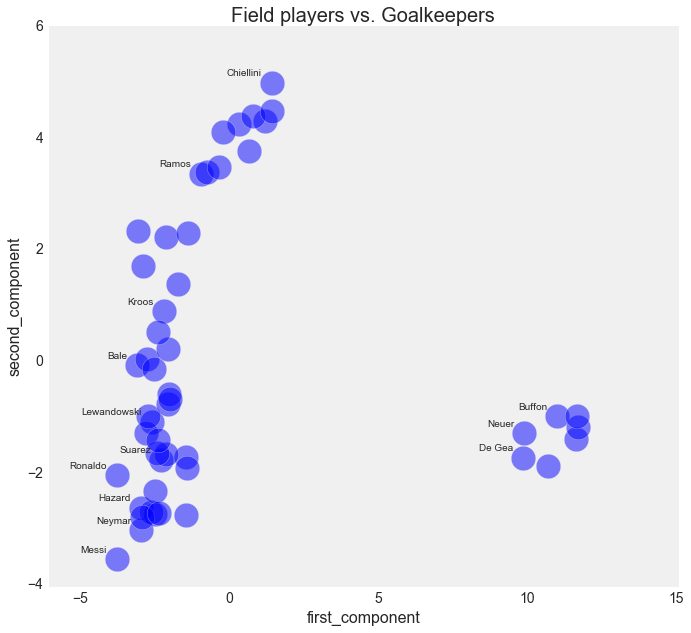

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.scatter(final.first_component, final.second_component, s=600, alpha=0.5)

ax.set_title('Field players vs. Goalkeepers', size=20)
ax.set_xlabel('first_component', size=16)
ax.set_ylabel('second_component', size=16)
ax.tick_params(labelsize=14)
ax.set_xlim(-6, 15)
ax.grid(False)

labels = ['Ronaldo', 'Messi', 'Neymar', 'Suarez', 'Neuer',
         'Lewandowski', 'De Gea', 'Hazard', 'Kroos',
         '', 'Ramos', 'Bale', 'Buffon', 'Chiellini']

for label, x, y in zip(labels,
                       final.first_component,
                       final.second_component):
    ax.annotate(label, xy=(x, y), xytext=(-10, 5),
               textcoords='offset points', ha='right', va='bottom')

Remember we had 7 goalkeepers in the top 50? They are those 7 dots at the bottom right corner of the scatterplot!

It looks like the first component is differentiating between field players and goalkeepers, and the second component is differentiating the field players themselves. We'll try removing the goalkeepers from the data set to be able to have 2 components that differentiate field players.

In [33]:
final.loc[final.first_component > 5, :]

,Name,first_component,second_component
4,M. Neuer,9.897268,-1.286419
6,De Gea,9.867425,-1.727868
12,G. Buffon,11.002236,-0.980031
17,T. Courtois,11.643721,-1.390708
23,H. Lloris,10.695054,-1.867871
32,J. Oblak,11.703517,-1.172635
36,S. Handanovič,11.650679,-0.970628


# Field players

In [41]:
field_players = final.loc[final.first_component < 5, :]

field_players.shape

(43, 3)

In [42]:
field_players.head()

,Name,first_component,second_component
0,Cristiano Ronaldo,-3.761511,-2.036917
1,L. Messi,-3.757096,-3.545738
2,Neymar,-2.950539,-3.023971
3,L. Suárez,-2.278626,-1.762801
5,R. Lewandowski,-2.582064,-1.083493


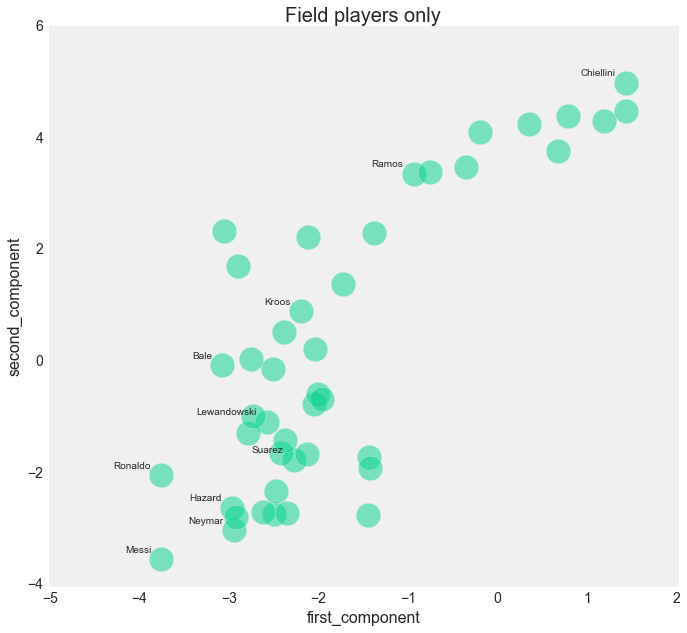

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.scatter(field_players.first_component, field_players.second_component, s=600,
           alpha=0.5, c='#00D48A')

ax.set_title('Field players only', size=20)
ax.set_xlabel('first_component', size=16)
ax.set_ylabel('second_component', size=16)
ax.tick_params(labelsize=14)
ax.grid(False)

labels = ['Ronaldo', 'Messi', 'Neymar', 'Suarez',
         'Lewandowski', 'Hazard', 'Kroos',
         '', 'Ramos', 'Bale', 'Chiellini']

for label, x, y in zip(labels,
                       field_players.first_component,
                       field_players.second_component):
    ax.annotate(label, xy=(x, y), xytext=(-10, 5),
               textcoords='offset points', ha='right', va='bottom')

In [37]:
field_players.loc[field_players.second_component > 4, :]

,Name,first_component,second_component
13,G. Chiellini,1.431848,4.994814
19,D. Godín,1.193964,4.309014
27,J. Boateng,0.347449,4.264559
28,L. Bonucci,-0.201393,4.121030
46,Javi Martínez,0.791725,4.405209
49,Sokratis,1.431789,4.495545


In [38]:
field_players.loc[field_players.second_component < -2, :]

,Name,first_component,second_component
0,Cristiano Ronaldo,-3.761511,-2.036917
1,L. Messi,-3.757096,-3.545738
2,Neymar,-2.950539,-3.023971
7,E. Hazard,-2.967642,-2.622033
14,S. Agüero,-2.498369,-2.734737
20,A. Robben,-2.617627,-2.699175
24,M. Özil,-1.443809,-2.758660
26,P. Dybala,-2.918887,-2.785933
31,A. Griezmann,-2.472937,-2.319025
48,D. Mertens,-2.355838,-2.723243


In [39]:
field_players.loc[field_players.first_component < -3, :]

,Name,first_component,second_component
0,Cristiano Ronaldo,-3.761511,-2.036917
1,L. Messi,-3.757096,-3.545738
11,G. Bale,-3.081380,-0.068234
40,A. Vidal,-3.053594,2.336861


In [40]:
field_players.loc[(field_players.first_component.between(-3, -2)) &
                  (field_players.second_component.between(-1, 1)), :]

,Name,first_component,second_component
8,T. Kroos,-2.199660,0.897233
16,L. Modrić,-2.759655,0.044246
18,K. De Bruyne,-2.730006,-0.977327
21,Z. Ibrahimović,-2.056936,-0.759104
30,Thiago,-2.513871,-0.133338
34,Iniesta,-2.002499,-0.578318
38,I. Rakitić,-2.036358,0.228841
39,M. Hamšík,-2.391333,0.521901


# Top 500 players

In [41]:
abilities = fifa.loc[fifa.index < 500, 'Acceleration':'Volleys'].copy()

In [42]:
abilities = pd.merge(fifa[['Name']], abilities, left_index=True, right_index=True)
abilities.sort_index(inplace=True)
abilities.sample(n=15)

,Name,Acceleration,Aggression,Agility,Balance,Ball control,Composure,Crossing,Curve,Dribbling,...,Reactions,Short passing,Shot power,Sliding tackle,Sprint speed,Stamina,Standing tackle,Strength,Vision,Volleys
364,K. Mitroglou,53,83,50,34,78,80,60,72,75,...,79,66,85,10,62,71,15,90,66,80
427,P. Hernández,72,87,72,52,80,67,54,75,81,...,82,82,75,70,70,73,68,80,81,69
304,D. Sánchez,65,85,62,55,64,72,36,22,54,...,74,65,74,85,76,79,82,86,44,28
450,Iago Falqué,80,48,85,86,85,78,78,80,84,...,78,80,62,32,79,77,36,53,78,69
68,P. Čech,40,17,49,34,22,70,19,13,12,...,84,35,21,12,44,32,13,65,53,17
160,B. Dost,54,72,38,35,73,78,38,62,64,...,85,74,83,26,64,84,48,89,68,85
425,K. Volland,78,75,73,84,81,80,78,79,79,...,81,81,85,33,77,88,50,82,81,76
474,V. Birsa,72,55,68,68,86,80,78,78,84,...,76,82,84,40,78,74,52,78,82,73
43,S. Handanovič,54,25,42,36,24,62,12,12,18,...,83,36,22,13,57,41,10,71,41,12
339,D. Lovren,57,87,53,43,67,70,59,26,63,...,75,68,63,85,55,70,83,86,56,42


In [43]:
X = abilities.loc[:, 'Acceleration':].copy()

In [44]:
X.shape

(500, 34)

In [45]:
X.columns

Index([u'Acceleration', u'Aggression', u'Agility', u'Balance', u'Ball control',
       u'Composure', u'Crossing', u'Curve', u'Dribbling', u'Finishing',
       u'Free kick accuracy', u'GK diving', u'GK handling', u'GK kicking',
       u'GK positioning', u'GK reflexes', u'Heading accuracy',
       u'Interceptions', u'Jumping', u'Long passing', u'Long shots',
       u'Marking', u'Penalties', u'Positioning', u'Reactions',
       u'Short passing', u'Shot power', u'Sliding tackle', u'Sprint speed',
       u'Stamina', u'Standing tackle', u'Strength', u'Vision', u'Volleys'],
      dtype='object')

In [46]:
X_transformed = pipe.fit_transform(X)

In [47]:
pipe.named_steps['decomposition'].explained_variance_ratio_

array([ 0.5843356 ,  0.18298331])

In [48]:
X_transformed.shape

(500, 2)

In [49]:
final = pd.DataFrame(X_transformed, columns=['first_component', 'second_component'])
final.head()

,first_component,second_component
0,-4.388496,2.530482
1,-4.398484,4.400852
2,-3.668912,3.969898
3,-2.874349,2.365027
4,10.078318,1.637105


In [50]:
final = pd.merge(fifa[['Name', 'Overall', 'Preferred Positions']], final,
                 left_index=True, right_index=True)
final.head()

,Name,Overall,Preferred Positions,first_component,second_component
0,Cristiano Ronaldo,94,A,-4.388496,2.530482
1,L. Messi,93,A,-4.398484,4.400852
2,Neymar,92,A,-3.668912,3.969898
3,L. Suárez,92,A,-2.874349,2.365027
4,M. Neuer,92,GK,10.078318,1.637105


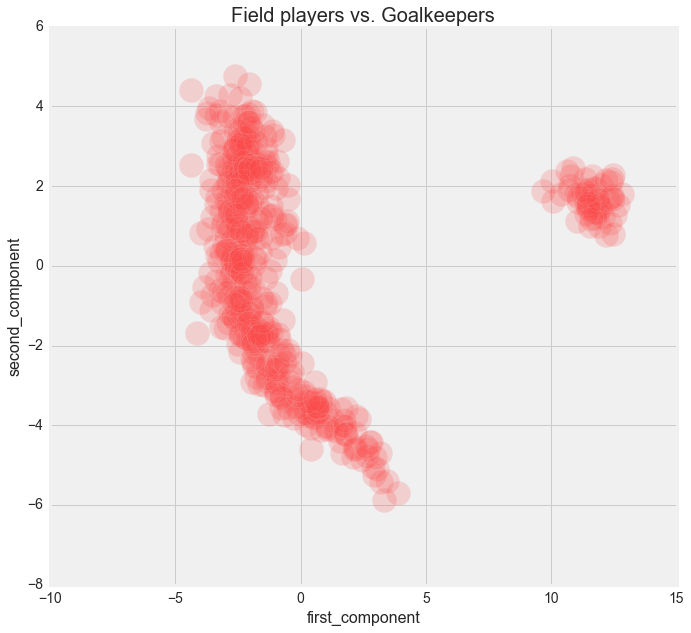

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.scatter(final.first_component, final.second_component, s=600,
           alpha=0.2, c='#FF4B4B')

ax.set_title('Field players vs. Goalkeepers', size=20)
ax.set_xlabel('first_component', size=16)
ax.set_ylabel('second_component', size=16)
ax.tick_params(labelsize=14)

In [52]:
final.loc[(final.first_component < -5) &
          (final.second_component > 4), :]

,Name,Overall,Preferred Positions,first_component,second_component


In [53]:
final.loc[final.second_component < -5, :]

,Name,Overall,Preferred Positions,first_component,second_component
79,K. Glik,85,D,3.305853,-5.877584
102,K. Koulibaly,84,D,3.186635,-5.411524
105,K. Manolas,84,D,3.025121,-5.101898
134,N. Süle,83,D,2.895724,-5.037416
268,F. Fazio,82,D,2.941771,-5.247223
419,Eric Botteghin,80,D,3.885594,-5.690604
493,G. Paletta,80,D,3.445745,-5.390260


In [54]:
final.loc[final.first_component > 5, :]

,Name,Overall,Preferred Positions,first_component,second_component
4,M. Neuer,92,GK,10.078318,1.637105
6,De Gea,90,GK,10.042098,2.121083
12,T. Courtois,89,GK,11.716351,1.945147
18,G. Buffon,89,GK,11.065958,1.599250
20,J. Oblak,88,GK,11.875644,1.616853
29,H. Lloris,88,GK,10.785905,2.257949
43,S. Handanovič,87,GK,11.756331,1.354596
68,P. Čech,86,GK,11.745813,1.938329
74,K. Navas,85,GK,11.475740,1.913689
76,D. Subašić,85,GK,11.521153,1.528027


# Field players

In [55]:
field_players = final.loc[final.first_component < 5, :]

field_players.shape

(442, 5)

In [56]:
field_players.head()

,Name,Overall,Preferred Positions,first_component,second_component
0,Cristiano Ronaldo,94,A,-4.388496,2.530482
1,L. Messi,93,A,-4.398484,4.400852
2,Neymar,92,A,-3.668912,3.969898
3,L. Suárez,92,A,-2.874349,2.365027
5,R. Lewandowski,91,A,-3.347998,1.730572


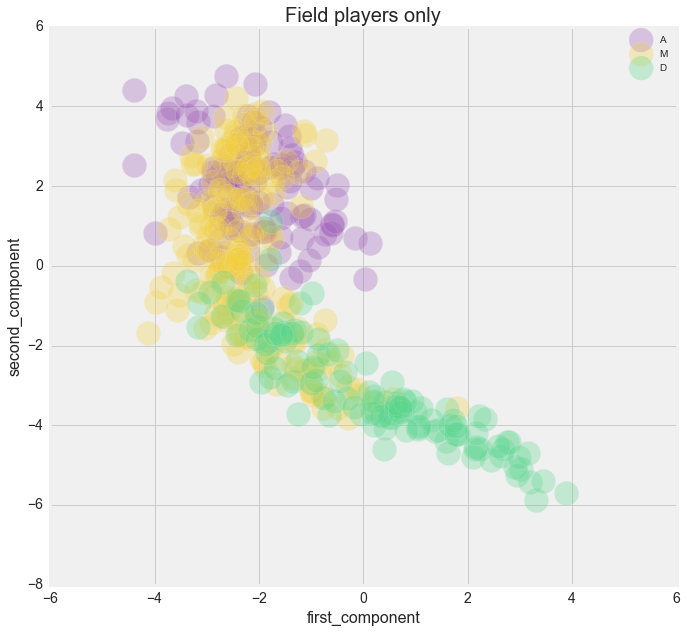

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

colours = ['#9B59B6', '#F4D03F', '#58D68D']
for i, pos in enumerate(field_players['Preferred Positions'].unique()):
    temp = field_players.loc[field_players['Preferred Positions'] == pos, :].copy()
    ax.scatter(temp.first_component, temp.second_component, s=600,
               alpha=0.3, c=colours[i], label=pos)

ax.set_title('Field players only', size=20)
ax.set_xlabel('first_component', size=16)
ax.set_ylabel('second_component', size=16)
ax.tick_params(labelsize=14)
ax.legend()

In [58]:
field_players.loc[field_players.second_component > 4, :]

,Name,Overall,Preferred Positions,first_component,second_component
1,L. Messi,93,A,-4.398484,4.400852
66,F. Ribéry,86,A,-2.824043,4.276704
72,L. Insigne,85,A,-2.624112,4.760625
168,S. Giovinco,83,A,-3.397108,4.269789
195,Quaresma,83,M,-2.441688,4.219386
230,Suso,82,A,-2.078174,4.559403


In [59]:
field_players.loc[field_players.second_component < -5, :]

,Name,Overall,Preferred Positions,first_component,second_component
79,K. Glik,85,D,3.305853,-5.877584
102,K. Koulibaly,84,D,3.186635,-5.411524
105,K. Manolas,84,D,3.025121,-5.101898
134,N. Süle,83,D,2.895724,-5.037416
268,F. Fazio,82,D,2.941771,-5.247223
419,Eric Botteghin,80,D,3.885594,-5.690604
493,G. Paletta,80,D,3.445745,-5.390260


In [60]:
field_players.loc[field_players.first_component < -4, :]

,Name,Overall,Preferred Positions,first_component,second_component
0,Cristiano Ronaldo,94,A,-4.388496,2.530482
1,L. Messi,93,A,-4.398484,4.400852
37,A. Vidal,87,M,-4.130622,-1.687960


In [61]:
field_players.loc[(field_players.first_component.between(-3, -2)) &
                  (field_players.second_component.between(-1, 1)), :]

,Name,Overall,Preferred Positions,first_component,second_component
34,M. Verratti,87,M,-2.689384,-0.523482
46,H. Kane,86,A,-2.366162,0.883538
65,Cesc Fàbregas,86,M,-2.973172,0.746489
80,Jordi Alba,85,D,-2.684587,-0.413737
96,D. Alli,84,M,-2.922568,-0.220181
104,Koke,84,M,-2.696072,0.356993
129,N. Keïta,83,M,-2.197435,0.672963
133,João Mário,83,M,-2.578565,-0.005216
157,Parejo,83,M,-2.445853,0.423698
171,A. Lallana,83,M,-2.729643,0.113902
